# [MI-BAY] Estimating error prediction

#### List of experiments
* [01 Original experiment](#01-Original-experiment)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.generic_utils import to_list

In [2]:
# Constants
SEED = 42  # Reproducibility

In [3]:
tf.random.set_seed(SEED)
np.random.seed(SEED)
experiments = {}  # Where experiments will be stored

In [4]:
def f_gen_data(n_train, f_xy, f_noise, n_test=0, *args, **kwargs):
    """Generate samples and labels for train and test.
    
    PARAMETERS
    ----------
    n_train: int
        Number of train samples to generate.
    f_xy: function()-> ( [feature1, feature2, ...], [target1, target2, etc] )
        Function that generates a tuple of 2 lists, features and targets.
        NOTE: features and targets can be tensors.
    f_noise: function([features]) -> [features]
        Function that adds noise to the features
    n_test: int
        Number of test samples to generate.
        
    RETURN
    ------
    ( ([train features], [train targets]), ([test features], [test targets]) )
    """
    assert(n_test>=0)
    n_samples = n_train + n_test
    x,y = f_xy_lineal(n_samples)
    # Add noise
    noise = f_noise(x)
    y_noise = tuple([y+noise for y, noise in zip(y, noise) ])
    i = np.random.shuffle(np.arange(n_samples))
    return(
        (  # Train data
            [x_feat[:n_train] for x_feat in x],
            [y_labl[:n_train] for y_labl in y_noise]
        ),
        (  # Test data
            [x_feat[n_train:] for x_feat in x],
            [y_labl[n_train:] for y_labl in y_noise]
        )
    )

In [5]:
def train_step(model, optimizer, f_loss, x_train, y_train):
    """Training step for a model.
    """
    with tf.GradientTape() as tape:
        predictions = to_list(model(x_train, training=True))
        loss = f_loss(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

## 01 Original experiment

#### References
* Post: [Predicting uncertainty with neural networks](https://medium.com/@steve_thorn/predicting-uncertainty-with-neural-networks-aec0217eb37d)
* [Notebook](https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty-variance.ipynb)

### Generate the synthetic data

In [6]:
def f_xy_lineal(n_samples):
    """Generate samples-labels
    
    RETURN:
     Tuple of tuples (inputs, outputs), 
    """
    x = tf.random.uniform(
        shape=(n_samples,1),
        minval=0.0,
        maxval=1.0
    )
    y = 2*x + 1
    return(([x],[y]))

In [7]:
def f_noise_gaussian_periodic(samples_x):
    """Generate noise for labels
    
    RETURN: 
     Tuple of tuples (noise for outputs)
    """
    noise = tf.random.normal(
        shape=samples_x[0].shape,
        mean=0.0,
        stddev=1.0
    )* 0.4 * np.sin(samples_x[0]*4*np.pi)
    return([noise])

In [8]:
experiments['original'] = {
    # Data generation
    'n_train': 10000,
    'n_test': 2000,
    'f_xy': f_xy_lineal,
    'f_noise': f_noise_gaussian_periodic,
    # Model hyperparameters
    'lr': 1e-4,
    'bs': 10000,  # Whole dataset
    'epochs': 10000,
}

In [9]:
(train_x, train_y), (test_x, test_y) = f_gen_data(**experiments['original'])

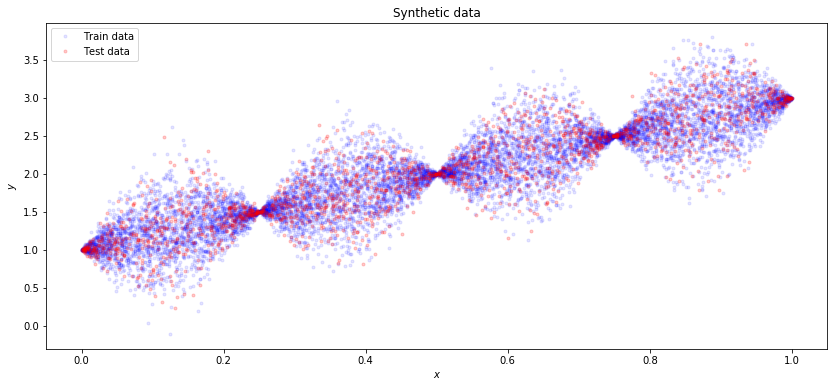

In [10]:
plt.figure(figsize=(14,6))
plt.plot(train_x[0], train_y[0], '.', color='blue', alpha=0.1)
plt.plot(test_x[0], test_y[0], '.', color='red', alpha=0.2)
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.legend([r'Train data','Test data'], loc='upper left', )
plt.title('Synthetic data')
plt.show()

### Train the model

In [11]:
def get_model01():
    in_x = tf.keras.Input(
        shape=(1,),
        name="x"
    )
    f1 = tf.keras.layers.Dense(
        1000,
        name="hidden",
        activation=tf.keras.activations.relu
    )(in_x)
    out_y = tf.keras.layers.Dense(
        1,
        name="y",
        activation=tf.keras.activations.linear
    )(f1)
    out_var = tf.keras.layers.Dense(
        1,
        name="y_var",
        activation=tf.keras.activations.linear
    )(f1)
    return tf.keras.Model(inputs=[in_x], outputs=[out_y, out_var], name="model01")

In [12]:
model01 = get_model01()
model01.summary()

Model: "model01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
hidden (Dense)                  (None, 1000)         2000        x[0][0]                          
__________________________________________________________________________________________________
y (Dense)                       (None, 1)            1001        hidden[0][0]                     
__________________________________________________________________________________________________
y_var (Dense)                   (None, 1)            1001        hidden[0][0]                     
Total params: 4,002
Trainable params: 4,002
Non-trainable params: 0
________________________

In [17]:
def loss01(y_true, y_pred):
    sqrt_err_y = (y_true[0]-y_pred[0])**2
    sqrt_err_estimation = (sqrt_err_y - y_pred[1])**2
    return([
        tf.reduce_mean(sqrt_err_y),
        tf.reduce_mean(sqrt_err_estimation)
    ])

In [16]:
{l.name: l for l in model01.layers}

{'hidden': <tensorflow.python.keras.layers.core.Dense at 0x7f537c403240>,
 'x': <tensorflow.python.keras.engine.input_layer.InputLayer at 0x7f537c4e75c0>,
 'y': <tensorflow.python.keras.layers.core.Dense at 0x7f537c4039b0>,
 'y_var': <tensorflow.python.keras.layers.core.Dense at 0x7f537c403ac8>}

In [32]:
def loss01_1(y_true, y_pred):
    y_error_sqrt = (y_true - y_pred[0])**2
    y_MSE = tf.reduce_mean(y_error_sqrt)
    variance_MSE = tf.reduce_mean((y_error_sqrt - y_pred[1])**2)
    return(y_MSE + variance_MSE)

In [33]:
# A small test
pred_y = model01.predict(train_x)
assert(pred_y[0].shape==pred_y[1].shape)
print(pred_y[0].shape)
loss01_1(train_y, pred_y)

(10000, 1)


<tf.Tensor: id=567868, shape=(), dtype=float32, numpy=30.65857>

#### Classic Keras

**NOTE**

If I try...
```python
model01.fit(
    x=train_x,
    y=train_y,
    batch_size=experiments['original']['bs'],
    epochs=experiments['original']['epochs'],
)
```

Keras complains the target shape is not as expected.
```
ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [<tf.Tensor:...
```

`F**k` keras, do the check on the returned value from the loss function!!!! Not on the training data.

#### Au naturel

In [34]:
optimizer01 = tf.keras.optimizers.Adam(
    learning_rate=experiments['original']['lr']
)

In [35]:
model=model01
f_loss=loss01_1
optimizer = optimizer01
batch_size  = experiments['original']['bs']
epochs = experiments['original']['epochs']
x_train = train_x
y_train = train_y

# Function

len_dataset = len(x_train[0])
indices = tf.range(len_dataset) # All indices for the dataset samples

for epoch in range(epochs):
    tf.random.shuffle(indices)
    i_batch = 0
    while i_batch<len_dataset:
        batch_indices = indices[i_batch:i_batch+batch_size]  # Stochastic batch selection
        loss = train_step(
            model,
            optimizer,
            f_loss,
            x_train=[
                tf.gather(params=feat_x, indices=batch_indices)
                for feat_x in x_train
            ],
            y_train=[
                tf.gather(params=feat_y, indices=batch_indices)
                for feat_y in y_train
            ],
        )
        i_batch += batch_size
    if epoch%100==0:
        print("Epoch: {}\tLoss: {}".format(epoch,loss))

Epoch: 0	Loss: 30.658573150634766
Epoch: 100	Loss: 14.944375991821289
Epoch: 200	Loss: 6.703580856323242
Epoch: 300	Loss: 2.891566753387451
Epoch: 400	Loss: 1.4546880722045898
Epoch: 500	Loss: 0.9644038677215576
Epoch: 600	Loss: 0.7733063697814941
Epoch: 700	Loss: 0.6599249839782715
Epoch: 800	Loss: 0.5632111430168152
Epoch: 900	Loss: 0.47060176730155945
Epoch: 1000	Loss: 0.38228505849838257
Epoch: 1100	Loss: 0.3017227351665497
Epoch: 1200	Loss: 0.2331310510635376
Epoch: 1300	Loss: 0.17993852496147156
Epoch: 1400	Loss: 0.1433108001947403
Epoch: 1500	Loss: 0.12136763334274292
Epoch: 1600	Loss: 0.1100102961063385
Epoch: 1700	Loss: 0.10487011820077896
Epoch: 1800	Loss: 0.10276477038860321
Epoch: 1900	Loss: 0.10193019360303879
Epoch: 2000	Loss: 0.10156656801700592
Epoch: 2100	Loss: 0.10136088728904724
Epoch: 2200	Loss: 0.10120359063148499
Epoch: 2300	Loss: 0.10105989873409271
Epoch: 2400	Loss: 0.10091995447874069
Epoch: 2500	Loss: 0.10078168660402298
Epoch: 2600	Loss: 0.10064497590065002
E

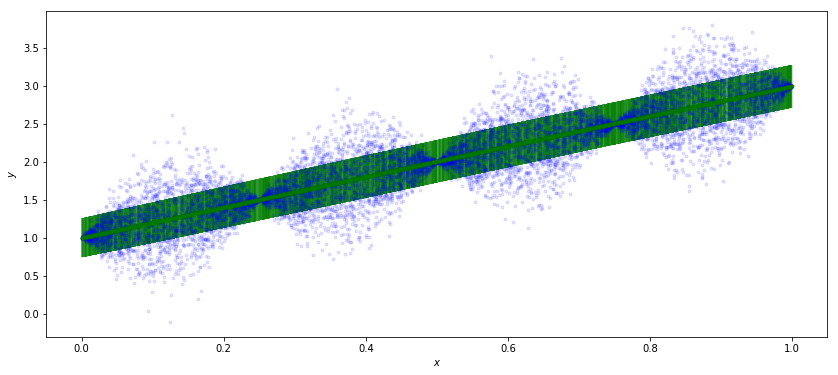

In [36]:
pred_y = model01.predict(train_x)

plt.figure(figsize=(14,6))
plt.plot(train_x[0], train_y[0], '.', color='blue', alpha=0.1)
plt.errorbar(train_x[0], pred_y[0], yerr=tf.sqrt(pred_y[1]), fmt='.', color='green', alpha=0.1);
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

[<tf.Tensor: id=1889248, shape=(), dtype=float32, numpy=0.0825634>, <tf.Tensor: id=1889250, shape=(), dtype=float32, numpy=0.02222623>]


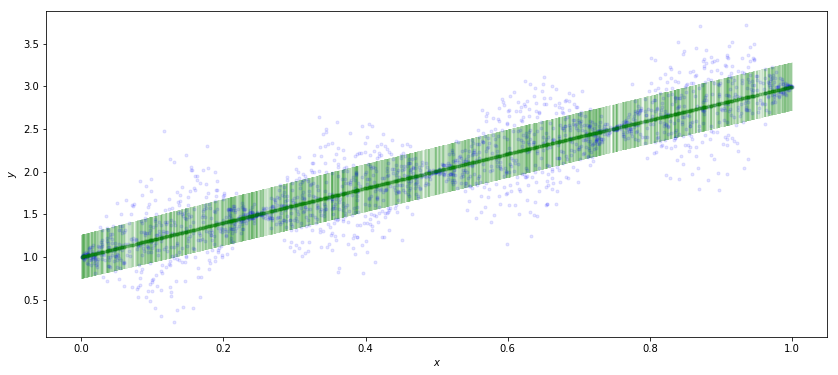

In [37]:
pred_y = model01.predict(test_x)
print(loss01(test_y, pred_y))

plt.figure(figsize=(14,6))
plt.plot(test_x[0], test_y[0], '.', color='blue', alpha=0.1)
plt.errorbar(test_x[0], pred_y[0], yerr=tf.sqrt(pred_y[1]), fmt='.', color='green', alpha=0.1);
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

### Train a model to fit 

In [45]:
x,y = f_xy_lineal(1)


In [47]:
y

[<tf.Tensor: id=1945380, shape=(1, 1), dtype=float32, numpy=array([[2.3460197]], dtype=float32)>]

In [40]:
x

array([0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4])